In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from __future__ import print_function
import string

import numpy as np
import scipy.sparse as sparse

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
data = pd.read_csv('input.csv',delimiter=';')

In [3]:
data = data.dropna()
print (data.shape)

(7999, 5)


In [4]:
print (data.head(3))

       Name      Artist     Mood  cluster  \
0  big-shot  billy-joel  Acerbic        3   
1  big-shot  billy-joel  Acerbic        4   
2  pressure  billy-joel  Acerbic        3   

                                              lyrics  
0  \tWell, you went uptown riding in your limousi...  
1  \tWell, you went uptown riding in your limousi...  
2  \tYou have to learn to pace yourself\tPressure...  


In [5]:
data.groupby('cluster')['lyrics'].count()

cluster
1    1493
2    1238
3    1877
4    1513
5    1878
Name: lyrics, dtype: int64

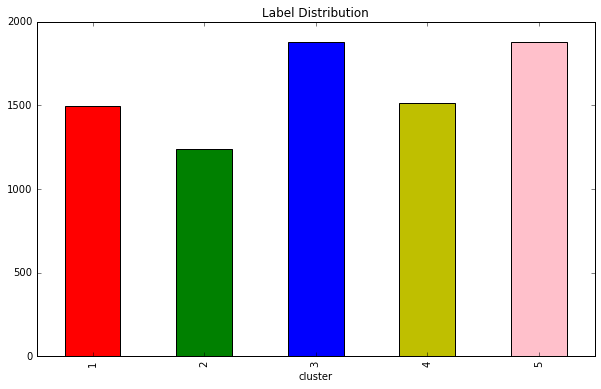

In [6]:
data.groupby('cluster')['lyrics'].count().plot(kind='bar',color=['r','g','b','y','pink'],title='Label Distribution',figsize=(10,6))

In [7]:
print ('Percentage of Cluster - 1 songs: %.2f %%' % ((data.groupby('cluster')['lyrics'].count()[1])*100.0/len(data)))
print ('Percentage of Cluster - 2 songs: %.2f %%' % ((data.groupby('cluster')['lyrics'].count()[2])*100.0/len(data)))
print ('Percentage of Cluster - 3 songs: %.2f %%' % ((data.groupby('cluster')['lyrics'].count()[3])*100.0/len(data)))
print ('Percentage of Cluster - 4 songs: %.2f %%' % ((data.groupby('cluster')['lyrics'].count()[4])*100.0/len(data)))
print ('Percentage of Cluster - 5 songs: %.2f %%' % ((data.groupby('cluster')['lyrics'].count()[5])*100.0/len(data)))

Percentage of Cluster - 1 songs: 18.66 %
Percentage of Cluster - 2 songs: 15.48 %
Percentage of Cluster - 3 songs: 23.47 %
Percentage of Cluster - 4 songs: 18.91 %
Percentage of Cluster - 5 songs: 23.48 %


In [8]:
def splitLyrics(input_data):
    c1 = data.loc[input_data['cluster']==1]
    c2 = data.loc[input_data['cluster']==2]
    c3 = data.loc[input_data['cluster']==3]
    c4 = data.loc[input_data['cluster']==4]
    c5 = data.loc[input_data['cluster']==5]
    return [c1,c2,c3,c4,c5]

In [9]:
[c1,c2,c3,c4,c5] = splitLyrics(data)

In [10]:
''''port = PorterStemmer()
wnl = WordNetLemmatizer()

def preprocessing(line):
    temp = " ".join([wnl.lemmatize(i) for i in line.split()])
    final = " ".join([port.stem(i) for i in temp.split()])
    final = final.lower().encode('utf-8')
    return final'''''

stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = string.maketrans(string.punctuation,' '*len(string.punctuation))



def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        if(1):
            temp = lemmatizer.lemmatize(t)
            stemmed = stemmer.stem(temp)
            tokens.append(stemmed)
    return ' '.join(tokens)

In [11]:
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []

for i in c1['lyrics']:
    cluster_1.append(preprocessing(i))
    
for i in c2['lyrics']:
    cluster_2.append(preprocessing(i))
    
for i in c3['lyrics']:
    cluster_3.append(preprocessing(i))
    
for i in c4['lyrics']:
    cluster_4.append(preprocessing(i))
    
for i in c5['lyrics']:
    cluster_5.append(preprocessing(i))
    

In [12]:
data = cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5
labels = np.concatenate((c1['cluster'].values,c2['cluster'].values,c3['cluster'].values,c4['cluster'].values,c5['cluster'].values))

In [78]:
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.1, random_state=19071994,stratify=labels)

In [79]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [80]:
word_features = nltk.FreqDist(t)
print (len(word_features))

16272


In [81]:
#PCA

In [82]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [83]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [84]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [85]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [86]:
te_features_truncated = svd.transform(te_features_all)

In [87]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

In [88]:
print (tr_features_all.shape)

(7199, 16237)


In [89]:
#running different models

In [91]:
BNB_clf = BernoulliNB(binarize=0.0)
BNB_clf.fit(tr_features_truncated, Train_labels)
tfpredict = BNB_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
BNB_clf.fit(ctr_features_truncated,Train_labels)
cprediction = BNB_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("BernoulliNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

BernoulliNB
TF-IDF Accuracy
0.2625
Count Accuracy
0.29375


In [93]:
pos_tr_features_truncated = []
xx=100005
for row in tr_features_truncated:
    lst = []
    for col in row:
        xx=min(xx,col)
        lst.append(col+0.388203518768)
    pos_tr_features_truncated.append(lst)
    
print (xx)
    
pos_ctr_features_truncated = []
for row in ctr_features_truncated:
    lst = []
    for col in row:
        xx=min(xx,col)
        lst.append(col+63.2554906989)
    pos_ctr_features_truncated.append(lst)
print (xx)

-0.388203518767
-63.2554906988


In [94]:
MNB_clf = MultinomialNB(alpha=0.1)
MNB_clf.fit(pos_tr_features_truncated, Train_labels)
tfpredict = MNB_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
MNB_clf.fit(pos_ctr_features_truncated,Train_labels)
cprediction = MNB_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("MultinomialNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

MultinomialNB
TF-IDF Accuracy
0.2975
Count Accuracy
0.235


In [95]:
LR_clf = linear_model.LogisticRegression(C=1e5)
LR_clf.fit(tr_features_truncated, Train_labels)
tfpredict = LR_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LR_clf.fit(ctr_features_truncated,Train_labels)
cprediction = LR_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Logistic")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Logistic
TF-IDF Accuracy
0.30625
Count Accuracy
0.29125


In [96]:
SVC_clf = svm.SVC()
SVC_clf.fit(tr_features_truncated, Train_labels)
tfpredict = SVC_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
SVC_clf.fit(ctr_features_truncated,Train_labels)
cprediction = SVC_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("SVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

SVC SVM
TF-IDF Accuracy
0.235
Count Accuracy
0.3025


In [97]:
NuSVC_clf = svm.NuSVC()
NuSVC_clf.fit(tr_features_truncated, Train_labels)
tfpredict = NuSVC_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
NuSVC_clf.fit(ctr_features_truncated,Train_labels)
cprediction = NuSVC_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("nuSVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

nuSVC SVM
TF-IDF Accuracy
0.26625
Count Accuracy
0.295


In [98]:
LinearSVC_clf = svm.LinearSVC()
LinearSVC_clf.fit(tr_features_truncated, Train_labels)
tfpredict = LinearSVC_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LinearSVC_clf.fit(ctr_features_truncated,Train_labels)
cprediction = LinearSVC_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("LinearSVC")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

LinearSVC
TF-IDF Accuracy
0.30625
Count Accuracy
0.2875


In [99]:
KNN_clf = KNeighborsClassifier(n_neighbors=5)
KNN_clf.fit(tr_features_truncated, Train_labels)
tfpredict = KNN_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
KNN_clf.fit(ctr_features_truncated,Train_labels)
cprediction = KNN_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("KNN")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

KNN
TF-IDF Accuracy
0.26625
Count Accuracy
0.2925


In [100]:
P_clf = linear_model.Perceptron(n_iter=1000)
P_clf.fit(tr_features_truncated, Train_labels)
tfpredict = P_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
P_clf.fit(ctr_features_truncated,Train_labels)
cprediction = P_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Perceptron")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Perceptron
TF-IDF Accuracy
0.19125
Count Accuracy
0.22


In [101]:
DT_clf = DecisionTreeClassifier(random_state=20160121, criterion='entropy')
DT_clf.fit(tr_features_truncated, Train_labels)
tfpredict = DT_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
DT_clf.fit(ctr_features_truncated,Train_labels)
cprediction = DT_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Decision Tree")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Decision Tree
TF-IDF Accuracy
0.27
Count Accuracy
0.27375


In [102]:
#Feature Selection

In [103]:
topwords = [fpair[0] for fpair in list(word_features.most_common(8500))]

In [104]:
print (word_features.most_common(20))

[(u'i', 66735), (u'the', 61344), (u'you', 59216), (u'a', 39609), (u'to', 35711), (u'and', 33413), (u'it', 27661), (u's', 26568), (u'me', 22831), (u't', 22550), (u'in', 21126), (u'my', 20204), (u'that', 16182), (u'of', 16165), (u'on', 14882), (u'love', 13013), (u'your', 12862), (u'm', 12833), (u'is', 12037), (u'be', 11304)]


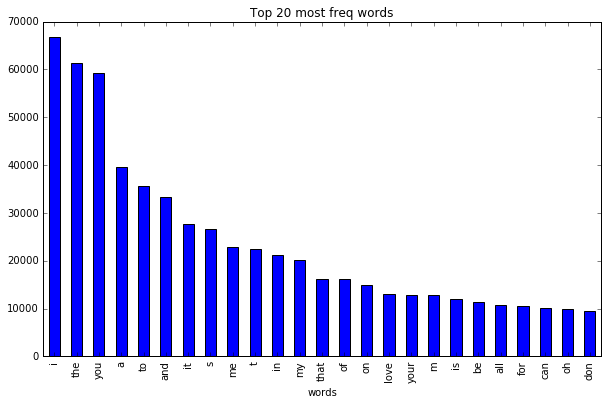

In [105]:
word_his = pd.DataFrame(word_features.most_common(25),columns=['words','count'])
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words',figsize=(10,6))

In [106]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

In [107]:
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [108]:
ctr_features = vec.transform(Data_train)
tr_features = tf_vec.transform(ctr_features)

In [109]:
cte_features = vec.transform(Data_test)
te_features = tf_vec.transform(cte_features)

In [110]:
#running different models for feature selection

In [111]:
BNB_clf = BernoulliNB(binarize=0.0)
BNB_clf.fit(tr_features, Train_labels)
tfpredict = BNB_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
BNB_clf.fit(ctr_features,Train_labels)
cprediction = BNB_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("BernoulliNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

BernoulliNB
TF-IDF Accuracy
0.29375
Count Accuracy
0.29375


In [112]:
MNB_clf = MultinomialNB()
MNB_clf.fit(tr_features, Train_labels)
tfpredict = MNB_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
MNB_clf.fit(ctr_features,Train_labels)
cprediction = MNB_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("MultinomialNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

MultinomialNB
TF-IDF Accuracy
0.3125
Count Accuracy
0.3225


In [113]:
LR_clf = linear_model.LogisticRegression(C=1e5)
LR_clf.fit(tr_features, Train_labels)
tfpredict = LR_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LR_clf.fit(ctr_features,Train_labels)
cprediction = LR_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Logistic")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Logistic
TF-IDF Accuracy
0.2925
Count Accuracy
0.29625


In [114]:
SVC_clf = svm.SVC()
SVC_clf.fit(tr_features, Train_labels)
tfpredict = SVC_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
SVC_clf.fit(ctr_features,Train_labels)
cprediction = SVC_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("SVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

SVC SVM
TF-IDF Accuracy
0.235
Count Accuracy
0.31125


In [115]:
NuSVC_clf = svm.NuSVC()
NuSVC_clf.fit(tr_features, Train_labels)
tfpredict = NuSVC_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
NuSVC_clf.fit(ctr_features,Train_labels)
cprediction = NuSVC_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("nuSVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

nuSVC SVM
TF-IDF Accuracy
0.2225
Count Accuracy
0.30625


In [116]:
LinearSVC_clf = svm.LinearSVC()
LinearSVC_clf.fit(tr_features, Train_labels)
tfpredict = LinearSVC_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LinearSVC_clf.fit(ctr_features,Train_labels)
cprediction = LinearSVC_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("LinearSVC")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

LinearSVC
TF-IDF Accuracy
0.3275
Count Accuracy
0.285


In [117]:
KNN_clf = KNeighborsClassifier(n_neighbors=5)
KNN_clf.fit(tr_features, Train_labels)
tfpredict = KNN_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
KNN_clf.fit(ctr_features,Train_labels)
cprediction = KNN_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("KNN")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

KNN
TF-IDF Accuracy
0.26375
Count Accuracy
0.26625


In [118]:
P_clf = linear_model.Perceptron(n_iter=1000)
P_clf.fit(tr_features, Train_labels)
tfpredict = P_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
P_clf.fit(ctr_features,Train_labels)
cprediction = P_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Perceptron")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Perceptron
TF-IDF Accuracy
0.2175
Count Accuracy
0.255


In [119]:
DT_clf = DecisionTreeClassifier(random_state=20160121, criterion='entropy')
DT_clf.fit(tr_features, Train_labels)
tfpredict = DT_clf.predict(te_features)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
DT_clf.fit(ctr_features,Train_labels)
cprediction = DT_clf.predict(cte_features)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Decision Tree")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Decision Tree
TF-IDF Accuracy
0.2775
Count Accuracy
0.2625


In [120]:
# Using Bigrams

In [121]:
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [122]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [123]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [124]:
print ((ctr_features_all.shape))

(7199, 144711)


In [125]:
BNB_clf = BernoulliNB(binarize=0.0)
BNB_clf.fit(tr_features_all, Train_labels)
tfpredict = BNB_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
BNB_clf.fit(ctr_features_all,Train_labels)
cprediction = BNB_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("BernoulliNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

BernoulliNB
TF-IDF Accuracy
0.295
Count Accuracy
0.295


In [126]:
MNB_clf = MultinomialNB()
MNB_clf.fit(tr_features_all, Train_labels)
tfpredict = MNB_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
MNB_clf.fit(ctr_features_all,Train_labels)
cprediction = MNB_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("MultinomialNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

MultinomialNB
TF-IDF Accuracy
0.30375
Count Accuracy
0.29875


In [127]:
LR_clf = linear_model.LogisticRegression(C=1e5)
LR_clf.fit(tr_features_all, Train_labels)
tfpredict = LR_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LR_clf.fit(ctr_features_all,Train_labels)
cprediction = LR_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Logistic")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Logistic
TF-IDF Accuracy
0.28875
Count Accuracy
0.2975


In [128]:
SVC_clf = svm.SVC()
SVC_clf.fit(tr_features_all, Train_labels)
tfpredict = SVC_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
SVC_clf.fit(ctr_features_all,Train_labels)
cprediction = SVC_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("SVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

SVC SVM
TF-IDF Accuracy
0.235
Count Accuracy
0.2675


In [77]:
NuSVC_clf = svm.NuSVC()
NuSVC_clf.fit(tr_features_all, Train_labels)
tfpredict = NuSVC_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
NuSVC_clf.fit(ctr_features_all,Train_labels)
cprediction = NuSVC_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("nuSVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

nuSVC SVM
TF-IDF Accuracy
0.20625
Count Accuracy
0.2975


In [78]:
LinearSVC_clf = svm.LinearSVC()
LinearSVC_clf.fit(tr_features_all, Train_labels)
tfpredict = LinearSVC_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LinearSVC_clf.fit(ctr_features_all,Train_labels)
cprediction = LinearSVC_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("LinearSVC")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

LinearSVC
TF-IDF Accuracy
0.30625
Count Accuracy
0.255


In [79]:
KNN_clf = KNeighborsClassifier(n_neighbors=5)
KNN_clf.fit(tr_features_all, Train_labels)
tfpredict = KNN_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
KNN_clf.fit(ctr_features_all,Train_labels)
cprediction = KNN_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("KNN")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

KNN
TF-IDF Accuracy
0.2875
Count Accuracy
0.2475


In [80]:
P_clf = linear_model.Perceptron(n_iter=1000)
P_clf.fit(tr_features_all, Train_labels)
tfpredict = P_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
P_clf.fit(ctr_features_all,Train_labels)
cprediction = P_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Perceptron")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Perceptron
TF-IDF Accuracy
0.26125
Count Accuracy
0.255


In [81]:
DT_clf = DecisionTreeClassifier(random_state=20160121, criterion='entropy')
DT_clf.fit(tr_features_all, Train_labels)
tfpredict = DT_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
DT_clf.fit(ctr_features_all,Train_labels)
cprediction = DT_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Decision Tree")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Decision Tree
TF-IDF Accuracy
0.275
Count Accuracy
0.27875


In [82]:
#Using Trigrams

In [129]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,3))
ctr_features_all = vec_all.fit_transform(Data_train)

In [130]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [131]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [132]:
print ((ctr_features_all.shape))

(7199, 395364)


In [133]:
BNB_clf = BernoulliNB(binarize=0.0)
BNB_clf.fit(tr_features_all, Train_labels)
tfpredict = BNB_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
BNB_clf.fit(ctr_features_all,Train_labels)
cprediction = BNB_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("BernoulliNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

BernoulliNB
TF-IDF Accuracy
0.29375
Count Accuracy
0.29375


In [134]:
MNB_clf = MultinomialNB()
MNB_clf.fit(tr_features_all, Train_labels)
tfpredict = MNB_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
MNB_clf.fit(ctr_features_all,Train_labels)
cprediction = MNB_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("MultinomialNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

MultinomialNB
TF-IDF Accuracy
0.30625
Count Accuracy
0.29625


In [89]:
LR_clf = linear_model.LogisticRegression(C=1e5)
LR_clf.fit(tr_features_all, Train_labels)
tfpredict = LR_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LR_clf.fit(ctr_features_all,Train_labels)
cprediction = LR_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Logistic")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Logistic
TF-IDF Accuracy
0.30125
Count Accuracy
0.29125


In [90]:
SVC_clf = svm.SVC()
SVC_clf.fit(tr_features_all, Train_labels)
tfpredict = SVC_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
SVC_clf.fit(ctr_features_all,Train_labels)
cprediction = SVC_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("SVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

SVC SVM
TF-IDF Accuracy
0.235
Count Accuracy
0.245


In [91]:
NuSVC_clf = svm.NuSVC()
NuSVC_clf.fit(tr_features_all, Train_labels)
tfpredict = NuSVC_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
NuSVC_clf.fit(ctr_features_all,Train_labels)
cprediction = NuSVC_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("nuSVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

nuSVC SVM
TF-IDF Accuracy
0.175
Count Accuracy
0.31375


In [92]:
LinearSVC_clf = svm.LinearSVC()
LinearSVC_clf.fit(tr_features_all, Train_labels)
tfpredict = LinearSVC_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LinearSVC_clf.fit(ctr_features_all,Train_labels)
cprediction = LinearSVC_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("LinearSVC")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

LinearSVC
TF-IDF Accuracy
0.31
Count Accuracy
0.2775


In [93]:
KNN_clf = KNeighborsClassifier(n_neighbors=5)
KNN_clf.fit(tr_features_all, Train_labels)
tfpredict = KNN_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
KNN_clf.fit(ctr_features_all,Train_labels)
cprediction = KNN_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("KNN")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

KNN
TF-IDF Accuracy
0.25375
Count Accuracy
0.24125


In [94]:
P_clf = linear_model.Perceptron(n_iter=1000)
P_clf.fit(tr_features_all, Train_labels)
tfpredict = P_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
P_clf.fit(ctr_features_all,Train_labels)
cprediction = P_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Perceptron")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Perceptron
TF-IDF Accuracy
0.255
Count Accuracy
0.25875


In [95]:
DT_clf = DecisionTreeClassifier(random_state=20160121, criterion='entropy')
DT_clf.fit(tr_features_all, Train_labels)
tfpredict = DT_clf.predict(te_features_all)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
DT_clf.fit(ctr_features_all,Train_labels)
cprediction = DT_clf.predict(cte_features_all)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Decision Tree")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Decision Tree
TF-IDF Accuracy
0.2775
Count Accuracy
0.2825


In [96]:
#PCA + bigram

In [135]:
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [136]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [137]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [138]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [139]:
te_features_truncated = svd.transform(te_features_all)

In [140]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

In [141]:
#running models

In [142]:
BNB_clf = BernoulliNB(binarize=0.0)
BNB_clf.fit(tr_features_truncated, Train_labels)
tfpredict = BNB_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
BNB_clf.fit(ctr_features_truncated,Train_labels)
cprediction = BNB_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("BernoulliNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

BernoulliNB
TF-IDF Accuracy
0.29875
Count Accuracy
0.2925


In [144]:
pos_tr_features_truncated = []
xx = 100005
for row in tr_features_truncated:
    lst = []
    for col in row:
        xx = min(xx,col)
        lst.append(col+0.528449036722)
    pos_tr_features_truncated.append(lst)
    
print (xx)

pos_ctr_features_truncated = []
for row in ctr_features_truncated:
    lst = []
    for col in row:
        xx = min(xx,col)
        lst.append(col+63.7196830705)
    pos_ctr_features_truncated.append(lst)
print (xx)

-0.528449036721
-63.7196830704


In [145]:
MNB_clf = MultinomialNB()
MNB_clf.fit(pos_tr_features_truncated, Train_labels)
tfpredict = MNB_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
MNB_clf.fit(pos_ctr_features_truncated,Train_labels)
cprediction = MNB_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("MultinomialNB")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

MultinomialNB
TF-IDF Accuracy
0.305
Count Accuracy
0.235


In [146]:
LR_clf = linear_model.LogisticRegression(C=1e5)
LR_clf.fit(tr_features_truncated, Train_labels)
tfpredict = LR_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LR_clf.fit(ctr_features_truncated,Train_labels)
cprediction = LR_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Logistic")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Logistic
TF-IDF Accuracy
0.31125
Count Accuracy
0.30625


In [147]:
SVC_clf = svm.SVC()
SVC_clf.fit(tr_features_truncated, Train_labels)
tfpredict = SVC_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
SVC_clf.fit(ctr_features_truncated,Train_labels)
cprediction = SVC_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("SVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

SVC SVM
TF-IDF Accuracy
0.235
Count Accuracy
0.2975


In [148]:
NuSVC_clf = svm.NuSVC()
NuSVC_clf.fit(tr_features_truncated, Train_labels)
tfpredict = NuSVC_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
NuSVC_clf.fit(ctr_features_truncated,Train_labels)
cprediction = NuSVC_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("nuSVC SVM")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

nuSVC SVM
TF-IDF Accuracy
0.27125
Count Accuracy
0.29


In [149]:
LinearSVC_clf = svm.LinearSVC()
LinearSVC_clf.fit(tr_features_truncated, Train_labels)
tfpredict = LinearSVC_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
LinearSVC_clf.fit(ctr_features_truncated,Train_labels)
cprediction = LinearSVC_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("LinearSVC")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

LinearSVC
TF-IDF Accuracy
0.30875
Count Accuracy
0.27


In [150]:
KNN_clf = KNeighborsClassifier(n_neighbors=5)
KNN_clf.fit(tr_features_truncated, Train_labels)
tfpredict = KNN_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
KNN_clf.fit(ctr_features_truncated,Train_labels)
cprediction = KNN_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("KNN")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

KNN
TF-IDF Accuracy
0.26625
Count Accuracy
0.30375


In [151]:
P_clf = linear_model.Perceptron(n_iter=1000)
P_clf.fit(tr_features_truncated, Train_labels)
tfpredict = P_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
P_clf.fit(ctr_features_truncated,Train_labels)
cprediction = P_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Perceptron")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Perceptron
TF-IDF Accuracy
0.2075
Count Accuracy
0.23375


In [152]:
DT_clf = DecisionTreeClassifier(random_state=20160121, criterion='entropy')
DT_clf.fit(tr_features_truncated, Train_labels)
tfpredict = DT_clf.predict(te_features_truncated)
tfaccuracy = metrics.accuracy_score(tfpredict,Test_labels)
DT_clf.fit(ctr_features_truncated,Train_labels)
cprediction = DT_clf.predict(cte_features_truncated)
caccuracy = metrics.accuracy_score(cprediction,Test_labels)
print ("Decision Tree")
print ("TF-IDF Accuracy")
print (tfaccuracy)
print ("Count Accuracy")
print (caccuracy)

Decision Tree
TF-IDF Accuracy
0.28
Count Accuracy
0.27125
